# 首先，确保环境配置好，在z_do_配置_预训练.ipynb
# 下载整理好的数据集
放在data目录下： \
watermelon
 --images
   --xxx.jpg
 --labelme_jsons

In [1]:
import os
os.chdir('./mmsegmentation')

In [2]:
# 确保自己的目录是正确的
os.getcwd()

'/root/autodl-tmp/mmseg/mmsegmentation'

In [2]:
# 导入
import os

import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# 可视化数据集

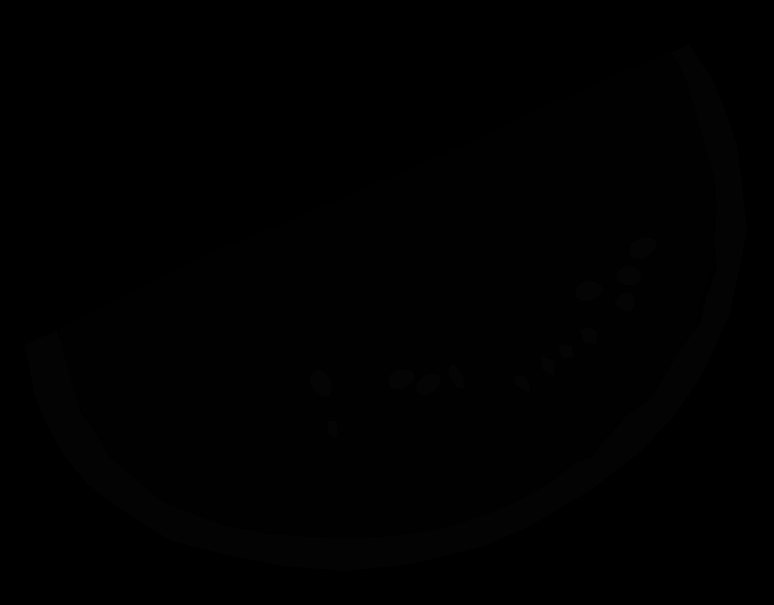

In [37]:
# 指定单张图像路径
img_path = 'data/Watermelon_Mask/img_dir/train/21746.1.jpg'
mask_path = 'data/Watermelon_Mask/ann_dir/train/21746.1.png'

Image.open(img_path)
Image.open(mask_path)

In [38]:
img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

In [39]:
# mask 语义分割标注，与原图大小相同
np.unique(mask)

array([0, 1, 3, 4], dtype=uint8)

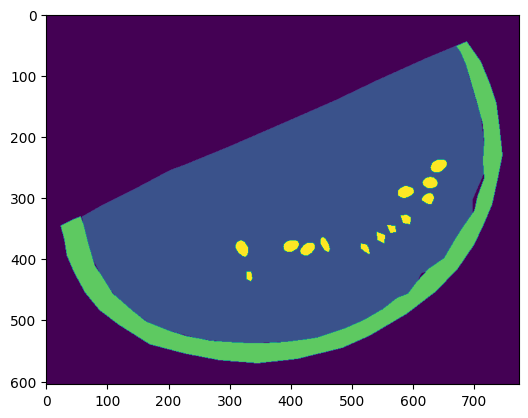

In [40]:
# 可视化语义分割标注
plt.imshow(mask[:,:,0])
plt.show()

# 配置文件
配置内容直接在DubaiDataset.py基础上修改 \
放在：\
watermelon/watermelon_config.py
pipeline配置文件：\
watermolon/__init__.py



In [3]:
# 载入配置文件
from mmengine import Config
cfg = Config.fromfile('./configs/pspnet/pspnet_r50-d8_4xb2-40k_watermelonDataset.py')

In [4]:
# 修改配置文件

cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head

# 模型 decode/auxiliary 输出头，指定为类别个数
cfg.model.decode_head.num_classes = 6
cfg.model.auxiliary_head.num_classes = 6

cfg.train_dataloader.batch_size = 16

cfg.test_dataloader = cfg.val_dataloader

# 结果保存目录
cfg.work_dir = './work_dirs/watermelonDataset'

# 训练迭代次数
cfg.train_cfg.max_iters = 3000
# 评估模型间隔
cfg.train_cfg.val_interval = 500
# 日志记录间隔
cfg.default_hooks.logger.interval = 500
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 500

# 随机数种子
cfg['randomness'] = dict(seed=0)

In [5]:
# 查看完整配置文件
print(cfg.pretty_text)

norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(64, 64))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(256, 256)),
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=51

In [6]:
# 保存配置文件
cfg.dump('pspnet-watermelonDataset_20230613.py')

## 载入修改过后的配置文件

In [7]:
# 载入新的配置文件
from mmengine import Config
cfg = Config.fromfile('pspnet-watermelonDataset_20230613.py')


In [20]:
!pwd

/root/autodl-tmp/mmseg/mmsegmentation


# 训练

In [8]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

/root/miniconda3/envs/mmseg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)
runner.train()

06/14 21:06:46 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Jun 12 2023, 18:09:05) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 3060
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50

/root/autodl-tmp/mmseg/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/root/autodl-tmp/mmseg/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/root/autodl-tmp/mmseg/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


06/14 21:06:55 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/14 21:06:55 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/root/autodl-tmp/mmseg/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


06/14 21:06:56 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
06/14 21:06:57 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
06/14 21:06:57 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
06/14 21:06:57 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

06/14 21:06:57 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
06/14 21:06:57 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
06/14 21:06:57 - mmengine - INFO - Checkpoints will be saved to /root/autodl-tmp/mmseg/mmsegmentation/work_dirs/watermelonDataset.
06/14 21:07:03 - mmengine - INFO - Exp name: pspnet-watermelonDataset_20230613_20230614_210646
06/14 21:11:54 - mmengine - INFO - Iter(trai

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

# 使用训练的模型进行预测

In [10]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules
from mmseg.apis import init_model, inference_model

In [11]:
# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner

register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

06/14 21:38:21 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Jun 12 2023, 18:09:05) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 3060
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50

/root/miniconda3/envs/mmseg/lib/python3.8/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(
/root/autodl-tmp/mmseg/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/root/autodl-tmp/mmseg/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/root/autodl-tmp/mmseg/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the 

06/14 21:38:24 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/14 21:38:24 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/root/autodl-tmp/mmseg/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [12]:
# 载入模型
checkpoint_path = './work_dirs/watermelonDataset/iter_3000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: ./work_dirs/watermelonDataset/iter_3000.pth


In [13]:
import mmcv
import cv2
# 载入测试图像
img = mmcv.imread('data/Watermelon_Mask/img_dir/train/0778_02.jpg')

In [14]:
# 预测
result = inference_model(model, img)

# 混淆矩阵

In [3]:
!pip install scikit-learn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 22.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 43.6 MB/s eta 0:00:00


In [15]:
label = mmcv.imread('data/Watermelon_Mask/ann_dir/train/0778_02.png')
label_mask = label[:,:,0]
result = inference_model(model, img)
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()

In [16]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

confusion_matrix_model = confusion_matrix(label_mask.flatten(), pred_mask.flatten())
confusion_matrix_model

def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('Confusion Matrix', fontsize=30)
    plt.xlabel('Pred', fontsize=25, c='r')
    plt.ylabel('True', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()



In [17]:
classes = ['/', 'red', 'green', 'white', 'seed-black', 'seed-white']

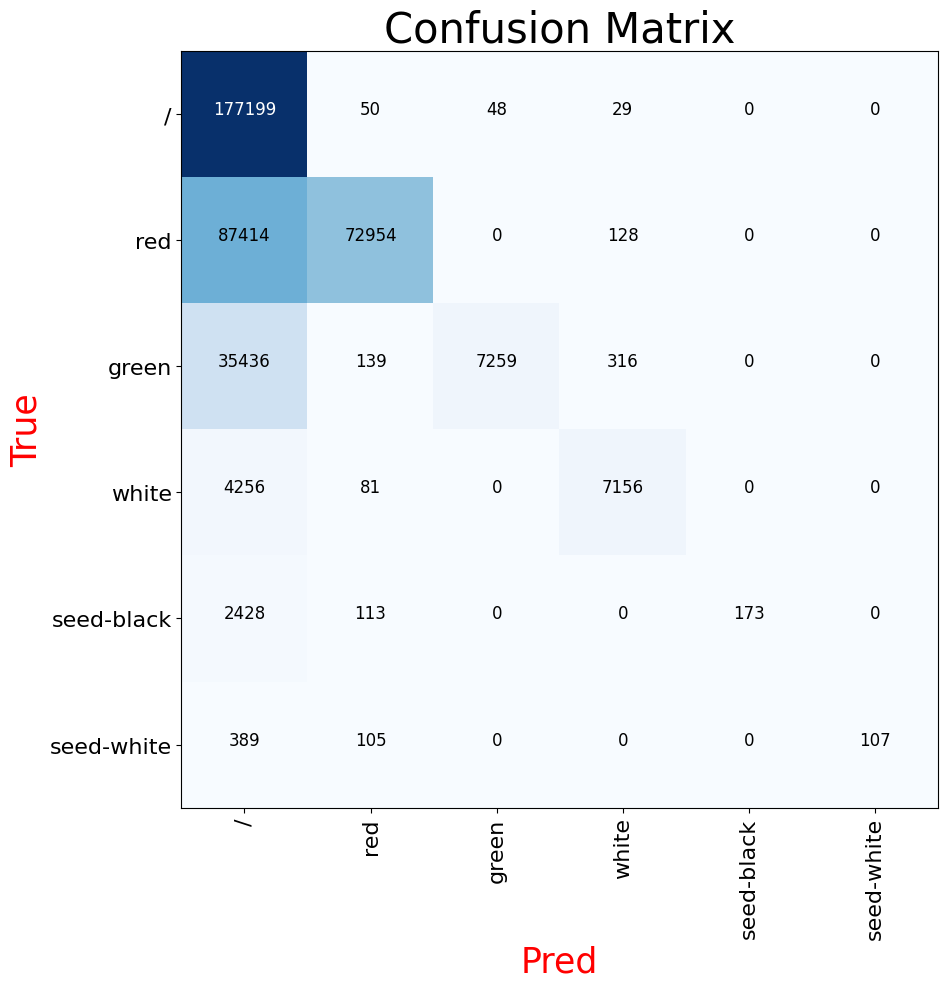

In [18]:
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')

# 测试集性能评估

In [21]:
# 精度指标
!python tools/test.py pspnet-watermelonDataset_20230613.py work_dirs/watermelonDataset/iter_3000.pth

06/14 21:41:09 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Jun 12 2023, 18:09:05) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 3060
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50

In [22]:
# 速度指标
!python tools/analysis_tools/benchmark.py pspnet-watermelonDataset_20230613.py work_dirs/watermelonDataset/iter_1000.pth

Run 1:
Traceback (most recent call last):
  File "/root/miniconda3/envs/mmseg/lib/python3.8/site-packages/mmengine/registry/build_functions.py", line 121, in build_from_cfg
    obj = obj_cls(**args)  # type: ignore
  File "/root/miniconda3/envs/mmseg/lib/python3.8/site-packages/mmsegmentation-1.0.0-py3.8.egg/mmseg/datasets/watermelonDataset.py", line 20, in __init__
    super().__init__(
  File "/root/miniconda3/envs/mmseg/lib/python3.8/site-packages/mmsegmentation-1.0.0-py3.8.egg/mmseg/datasets/basesegdataset.py", line 142, in __init__
    self.full_init()
  File "/root/miniconda3/envs/mmseg/lib/python3.8/site-packages/mmengine/dataset/base_dataset.py", line 310, in full_init
    self.data_bytes, self.data_address = self._serialize_data()
  File "/root/miniconda3/envs/mmseg/lib/python3.8/site-packages/mmengine/dataset/base_dataset.py", line 772, in _serialize_data
    data_bytes = np.concatenate(data_list)
  File "<__array_function__ internals>", line 200, in concatenate
ValueError: n